[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ducis28/sg-dlfs4/blob/main/dlfs4_ch05.ipynb)

# 『ゼロから作るDeep Learning ❹ 強化学習編』

https://github.com/oreilly-japan/deep-learning-from-scratch-4

## 第5章 モンテカルロ法

一般には「環境のモデル（状態遷移確率と報酬関数）」の情報は既知ではない。エージェントがインタラクションによって情報を少しづつ得ることが多い。

モンテカルロ法は，データのサンプリングを繰り返しおこなって，その結果から推定する手法の総称である。

本章の目標は，エージェントが得た景観をもとに価値関数を推定することである。その後，最適方策の推定に進む。

In [ ]:
%pip install dezerogym

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 5.1 モンテカルロ法の基礎

- **分布モデル (distribution model)**: 確率分布としてモデル化する
- **サンプルモデル (sample model)**: 確率分布が定まらなくても，サンプリングさえできればよい

In [ ]:
# 分布モデルの例（２つのサイコロの目の和の期待値）

from collections import defaultdict

ps = defaultdict(lambda: 0)
for d1 in range(1, 7):
    for d2 in range(1, 7):
        ps[d1 + d2] += 1 / 36

V = 0
for x, p in ps.items():
    V += x * p
print(V)

7.0


In [ ]:
# サンプルモデルの例（２つのサイコロの目の和）

import numpy as np

def sample(dices=2):
    x = 0
    for _ in range(dices):
        x += np.random.choice([1, 2, 3, 4, 5, 6])
    return x

print(sample())
print(sample())
print(sample())

trial = 1000
samples = []
for _ in range(trial):
    s = sample()
    samples.append(s)

V = sum(samples) / len(samples)
print(V)

8
6
5
6.994


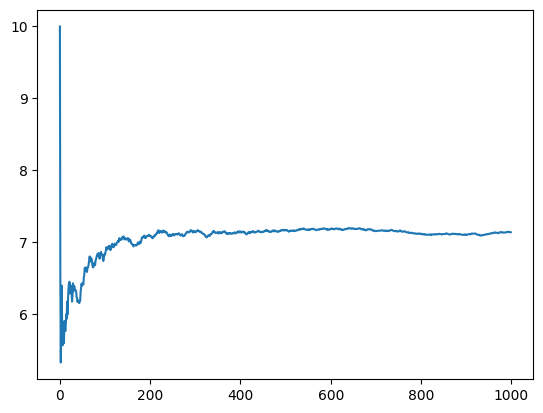

In [ ]:
# サンプルモデルで期待値を毎回計算する

import matplotlib.pyplot as plt

trial = 1000
samples = []
avgs = []
for _ in range(trial):
    s = sample()
    samples.append(s)
    V = sum(samples) / len(samples)
    avgs.append(V)
plt.plot(avgs)
plt.show()

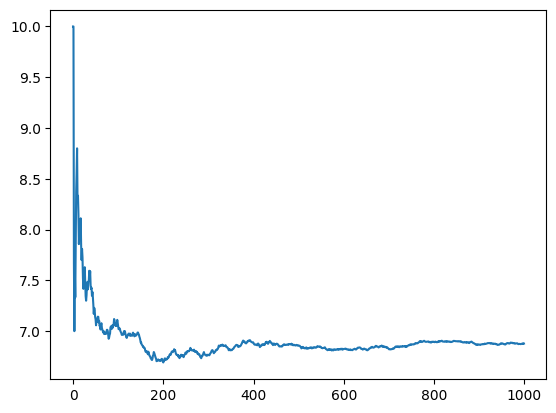

In [ ]:
# サンプルモデルで期待値を毎回計算する（インクリメンタル版）

import matplotlib.pyplot as plt

trial = 1000
V = 0

avgs = []
for n in range(1, trial + 1):
    s = sample()
    V += (s - V) / n
    avgs.append(V)
plt.plot(avgs)
plt.show()

### 5.2 モンテカルロ法による方策評価

価値関数

$$
v_\pi(s) = \mathbb{E}\left[G\mid s\right]
$$

$i$回目のエピソードで得られた収益を $G^{(i)}$ のように表記すると

$$
V_\pi(s) = \frac{G^{(1)}+G^{(2)}+\cdots+G^{(n)}}{n}
$$

### 5.3 モンテカルロ法の実装

In [ ]:
#@title 5.3.1 stepメソッド

from dezerogym.gridworld import GridWorld

env = GridWorld()

action = 0  # ダミーの行動

next_state, reward, done = env.step(action)

print(f'{next_state = }')
print(f'{reward = }')
print(f'{done = }')

next_state = (1, 0)
reward = 0
done = False


In [ ]:
#@title 5.3.2 エージェントクラスの実装

from collections import defaultdict

import numpy as np


class RandomAgent:
    def __init__(self):
        # 基本的なパラメータ
        self.gamma = 0.9  # 収益の割引率
        self.action_size = 4  # 行動のサイズ

        # ランダムな方策
        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}

        # 方策
        self.pi = defaultdict(lambda: random_actions)

        # 状態価値関数
        self.V = defaultdict(lambda: 0)

        # これまでに実行したエピソードの数
        # （インクリメンタルに収益を求めるために必要）
        self.cnts = defaultdict(lambda: 0)

        # これまでの経験データ（状態，行動，報酬）
        self.memory = []

    # 方策 pi にしたがって行動を選択する
    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    # 経験データを記録する
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)
    
    # 経験データを消去する
    def reset(self):
        self.memory.clear()

    # 評価
    def eval(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            self.cnts[state] += 1
            self.V[state] += (G - self.V[state]) / self.cnts[state]

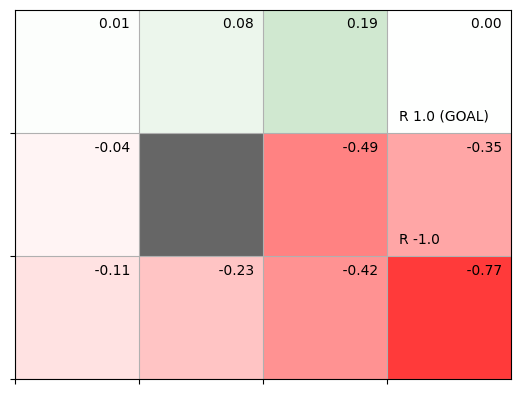

In [ ]:
#@title 5.3.3 モンテカルロ法を動かす

env = GridWorld()
agent = RandomAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()  # 初期状態は左下 (2,0)
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.eval()
            break
        
        state = next_state

env.render_v(agent.V)

### 5.4 モンテカルロ法による方策制御

- 前節は「方策評価」
- 本節は「方策制御」で最適方策を見つける

方策の「更新式」

$$
\begin{align*}
\mu(s)
&= \mathop{\rm argmax}_a Q(s,a)
\\
&= \mathop{\rm argmax}_a \sum_{s'} p(s'\mid s,a) \bigl\{ r(s,a,s') + \gamma \cdot V(s') \bigr\}
\end{align*}
$$

一般の強化学習では $p(s'\mid s,a)$ や $r(s,a,s')$ を知ることができない。したがって，Q関数を用いる式を用いる。この $Q$ 関数はモンテカルロ法などによって推定する。

【状態価値関数にかんしての評価】
- 一般的な方式: $\displaystyle V_n(s)=\frac{G^{(1)}+G^{(2)}+\cdots+G^{(n)}}{n}$
- インクリメンタルな方式: $\displaystyle V_n(s)=V_{n-1}(s)+\frac{1}{n}\left\{G^{(n)}-V_{n-1}(s)\right\}$

【Q関数にかんしての評価】
- 一般的な方式: $\displaystyle Q_n(s,a)=\frac{G^{(1)}+G^{(2)}+\cdots+G^{(n)}}{n}$
- インクリメンタルな方式: $\displaystyle Q_n(s,a)=Q_{n-1}(s,a)+\frac{1}{n}\left\{G^{(n)}-Q_{n-1}(s,a)\right\}$

In [ ]:
#@title 5.4.2 モンテカルロ法を使った方策制御の実装

from collections import defaultdict

import numpy as np


def greedy_probs(Q, state, action_size=4):
    qs = [Q[state, action] for action in range(action_size)]
    max_action = np.argmax(qs)

    action_probs = {action: 0.0 for action in range(action_size)}
    action_probs[max_action] = 1
    return action_probs


class McAgent:
    def __init__(self):
        # 基本的なパラメータ
        self.gamma = 0.9  # 収益の割引率
        self.action_size = 4  # 行動のサイズ

        # ランダムな方策
        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}

        # 方策
        self.pi = defaultdict(lambda: random_actions)

        # Q関数
        self.Q = defaultdict(lambda: 0)

        # これまでに実行したエピソードの数
        # （インクリメンタルに収益を求めるために必要）
        self.cnts = defaultdict(lambda: 0)

        # これまでの経験データ（状態，行動，報酬）
        self.memory = []

    # 方策 pi にしたがって行動を選択する
    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    # 経験データを記録する
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)
    
    # 経験データを消去する
    def reset(self):
        self.memory.clear()

    # 更新
    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.cnts[key] += 1
            self.Q[key] += (G - self.Q[key]) / self.cnts[key]
            self.pi[state] = greedy_probs(self.Q, state)

このコードは，うまく行かない。

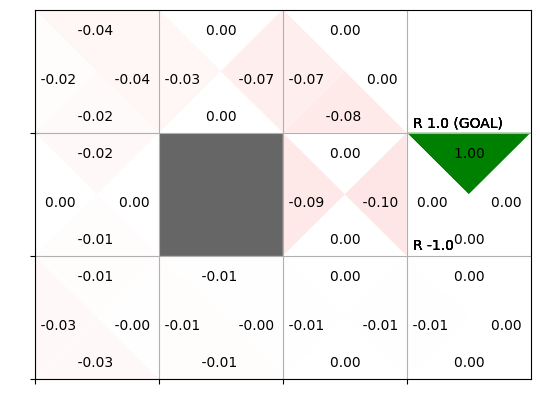

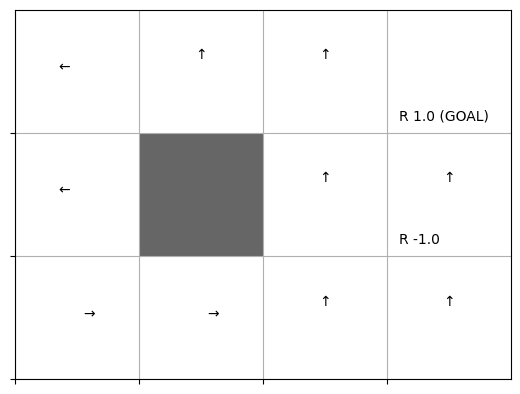

In [ ]:
env = GridWorld()
agent = McAgent()

episodes = 1000
for episode in range(episodes):
    state = env.reset()  # 初期状態は左下 (2,0)
    agent.reset()

    for repeat in range(1000):
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break
        
        state = next_state

env.render_q(agent.Q)

うまく行かない原因はいくつかある。
- つねに max を選ぶ greedy では「探索」が足りない

In [ ]:
#@title 5.4.3 ε-greedy 法（1つ目の修正）

def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[state, action] for action in range(action_size)]
    max_action = np.argmax(qs)

    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}
    action_probs[max_action] += 1 - epsilon
    return action_probs

In [ ]:
#@title 5.4.4 固定値α方式へ（2つ目の修正）

class McAgent2(McAgent):
    # 更新
    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.cnts[key] += 1
            alpha = 0.1
            self.Q[key] += (G - self.Q[key]) * alpha
            self.pi[state] = greedy_probs(self.Q, state)

この修正によって，標本平均でなく指数移動平均（第1章を参照）を用いるようになる。

平均をとる際に，古い経験（先頭寄りのデータ）よりも新しい経験（末尾寄りのデータ）を重視するようになる。ここでは reversed を使っているため，末尾寄りのデータ（エピソードの終了が近い，部分エピソードとしては短いもの）よりも先頭寄りのデータ（エピソードの開始に近い，部分エピソードとしては長いもの）を重視することになる。

書籍p.155 の「エピソードが進むに従い方策が更新されていくため」というのは少し違うような。なぜなら，方策が更新されるのは update が呼び出されるタイミング，つまり，1エピソードが終わったタイミングであって，指数移動平均が適用されるのはエピソードをまたがず1つのエピソードから得たサンプル集合の平均であるから。

In [ ]:
#@title 5.4.5 ［修正版］モンテカルロ法を使った方策制御の実装

from collections import defaultdict

import numpy as np


class McAgent:
    def __init__(self):
        # 基本的なパラメータ
        self.gamma = 0.9      # 収益の割引率
        self.epsilon = 0.1    # ε-greedyのε
        self.alpha = 0.1      # Q 値を更新する際の固定値 alpha
        self.action_size = 4  # 行動のサイズ

        # ランダムな方策
        random_actions = {action: 1 / self.action_size for action in range(self.action_size)}

        # 方策
        self.pi = defaultdict(lambda: random_actions)

        # Q関数
        self.Q = defaultdict(lambda: 0)

        # これまでの経験データ（状態，行動，報酬）
        self.memory = []

    # 方策 pi にしたがって行動を選択する
    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)
    
    # 経験データを記録する
    def add(self, state, action, reward):
        data = (state, action, reward)
        self.memory.append(data)
    
    # 経験データを消去する
    def reset(self):
        self.memory.clear()

    # 更新
    def update(self):
        G = 0
        for data in reversed(self.memory):
            state, action, reward = data
            G = self.gamma * G + reward
            key = (state, action)
            self.Q[key] += (G - self.Q[key]) * self.alpha
            self.pi[state] = greedy_probs(self.Q, state, self.epsilon)

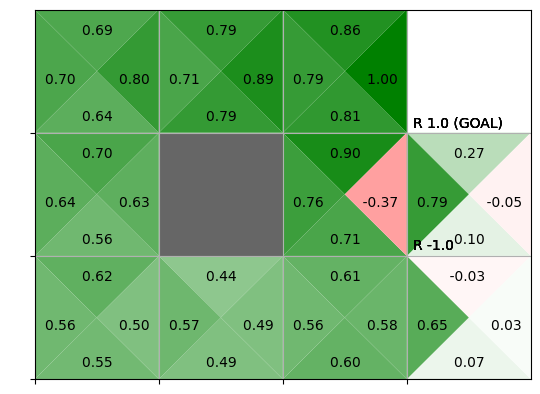

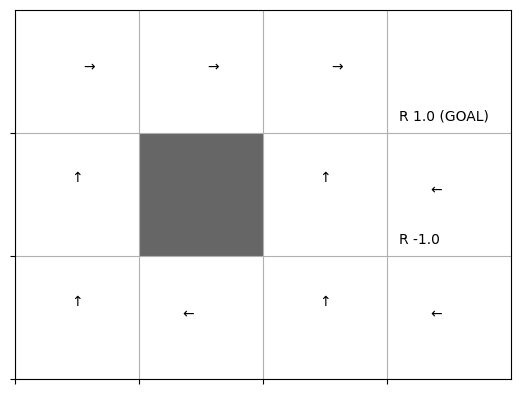

In [ ]:
env = GridWorld()
agent = McAgent()

episodes = 10000
for episode in range(episodes):
    state = env.reset()  # 初期状態は左下 (2,0)
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.add(state, action, reward)
        if done:
            agent.update()
            break
        
        state = next_state

env.render_q(agent.Q)

### 5.5 方策オフ型と重点サンプリング

「探索」は一種の妥協であると考えられる。モンテカルロ法を用いて，完全に最適な方策を学習することは可能か？

学習の方法

- **方策オフ型 (off-policy)**: 自分とは別の場所で得られた経験から自分の方策を改善すること
- **方策オン型 (on-policy)**: 自分で得た経験から自分の方策を改善すること

よく考えてみると，シミュレーションにおいて，現時点までに獲得したベストな方策と，「実際のふるまい」で用いる方策が同じである必要はない。

- **ターゲット方策 (target policy)**: 評価と改善の対象となる方策
- **挙動方策 (behavior policy)**: エージェントが実際に行動を起こす際に使う方策

ターゲット方策と挙動方策が同じなのは方策オン型，2つの方策を分けて考えるのは方策オフ型である。

#### 重点サンプリング (importance sampling)

確率変数 $x$ の期待値は

$$
\mathbb{E}_\pi\left[x\right] = \sum x \pi(x)
$$

この期待値をモンテカルロ法で近似すると

$$
\begin{align*}
& x^{(i)} \sim \pi \quad\text{($i=1,2,\cdots,n$)}
\\
& \mathbb{E}_\pi\left[x\right] \simeq \frac{x^{(1)}+x^{(2)}+\cdots+x^{(n)}}{n}
\end{align*}
$$

異なる確率分布による期待値

$$
\begin{align*}
\mathbb{E}_\pi\left[x\right]
&= \sum x \pi(x)
\\
&= \sum x \frac{\pi(x)}{b(x)} b(x)
\\
&= \mathbb{E}_b\left[ x \frac{\pi(x)}{b(x)} \right]
\end{align*}
$$

$\rho(x)=\frac{\pi(x)}{b(x)}$ とすれば

$$
\begin{align*}
& x^{(i)} \sim b \quad\text{($i=1,2,\cdots,n$)}
\\
& \mathbb{E}_\pi\left[x\right] \simeq \frac{\rho(x^{(1)})x^{(1)}+\rho(x^{(2)})x^{(2)}+\cdots+\rho(x^{(n)})x^{(n)}}{n}
\end{align*}
$$

In [ ]:
import numpy as np

# 確率変数 x が取りうる値
x = np.array([1, 2, 3])

# 未知の確率分布 pi
pi = np.array([0.1, 0.1, 0.8])

# 期待値
e = np.sum(x * pi)
print('E_pi[x]', e)

E_pi[x] 2.7


In [ ]:
# 確率分布 pi の期待値を通常のモンテカルロ法で求める

n = 100
samples = []
for _ in range(n):
    s = np.random.choice(x, p=pi)  # piを使ってサンプリング
    samples.append(s)

mean = np.mean(samples)
var = np.var(samples)
print('MC: {:.2f} (var: {:.2f})'.format(mean, var))

MC: 2.83 (var: 0.24)


In [ ]:
# 重点サンプリングを用いる

# 別の確率分布 b を定義する
b = np.array([1/3, 1/3, 1/3])

# 重点サンプリング
n = 100
samples = []
for _ in range(n):
    idx = np.arange(len(b))  # [0, 1, 2]
    i = np.random.choice(idx, p=b)  # bを使ってサンプリング
    s = x[i]
    rho = pi[i] / b[i]
    samples.append(rho * s)

mean = np.mean(samples)
var = np.var(samples)
print('IS: {:.2f} (var: {:.2f})'.format(mean, var))

IS: 2.80 (var: 10.43)


重点サンプリングの結果は悪くないが，分散が大きい。確率分布 $b$ が真の確率分布 $\pi$ に近づくほど分散が小さくなる。

In [ ]:
# 重点サンプリングを用いる

# 別の確率分布 b を定義する
b = np.array([0.2, 0.2, 0.6])

# 重点サンプリング
n = 100
samples = []
for _ in range(n):
    idx = np.arange(len(b))  # [0, 1, 2]
    i = np.random.choice(idx, p=b)  # bを使ってサンプリング
    s = x[i]
    rho = pi[i] / b[i]
    samples.append(rho * s)

mean = np.mean(samples)
var = np.var(samples)
print('IS: {:.2f} (var: {:.2f})'.format(mean, var))

IS: 2.84 (var: 2.52)


詳細は付録Ａを参照

### 5.6 まとめ

エージェントは環境と相互作用して方策を学習する。エージェントが環境に対して行動をおこすことによってフィードバックを得る。強化学習では，そこで得られた経験をもとに方策を改善する。

通常は，環境についての情報をすべて得られるわけではないため，モンテカルロ法を用いる。モンテカルロ法では，サンプリングした結果から価値関数や Q 関数の確率分布を推定する。

エージェントの方策には 2 通りある
- **ターゲット方策**: 改善の対象となる方策
- **挙動方策**: 実際の行動をおこなう方策

方策の学習において，この 2 つの方策が一致するような場合を **方策オン型（オンポリシー）** ，2 つを分けて考える場合を **方策オフ型（オフポリシー）** とよぶ。

### おまけ

グリッドワールド環境の可視化について

- https://github.com/oreilly-japan/deep-learning-from-scratch-4/blob/master/common/gridworld_render.py

[[ 3.97245726e-01  9.19624695e-01 -1.33963264e-01 -7.91739735e-01]
 [ 2.83321836e-01  6.28291423e-01  1.14654696e-02 -5.61500698e-01]
 [ 1.91159118e-04  1.20778478e-01  4.72130442e-01  7.30274880e-01]]


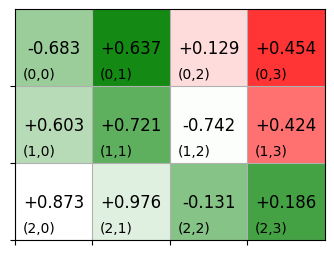

In [46]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def render_v(V):
    H, W = V.shape

    # グラフ描画の初期設定
    figsize = [4, 3]  # [6.4, 4.8]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.clear()

    # 軸の目盛り
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax.set_yticks(range(H))
    ax.set_xticks(range(W))
    ax.set_ylim(0, H)
    ax.set_xlim(0, W)

    # 格子を表示させる
    ax.grid(True)

    # color map
    color_list = ['red', 'white', 'green']
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)

    # データの最大値・最小値
    vmax = max(1, abs(V.min()), abs(V.min()))
    vmin = - vmax

    # グラフを描画する
    #   imshow() を用いる方法もある
    ax.pcolormesh(np.flipud(V), cmap=cmap, vmin=vmin, vmax=vmax)

    # 各セルに文字を表示する
    for y in range(H):
        for x in range(W):
            ax.text(x + .1, ((H - y - 1) + .1), f'({y},{x})')
            ax.text(
                x + .5, ((H - y - 1) + .5),
                f'{D[y,x]:+.3f}',
                horizontalalignment='center',
                verticalalignment='center',
                fontsize=12,
            )
    
    plt.show()


# ダミーデータをランダムに生成する
V = np.random.rand(3, 4) * 2 - 1
print(V)

# 描画する
render_v(V)

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3)]
[0, 1, 2, 3]
48


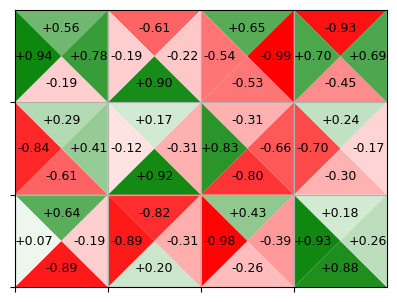

In [24]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def render_q(Q):
    Y, X, A = set(), set(), set()
    for key, value in Q.items():
        state, action = key
        y, x = state
        Y.add(y)
        X.add(x)
        A.add(action)

    H, W = len(Y), len(X)

    # グラフ描画の初期設定
    figsize = [4.8, 3.6]  # [6.4, 4.8]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    ax.clear()

    # 軸の目盛り
    ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
    ax.set_yticks(range(H))
    ax.set_xticks(range(W))
    ax.set_ylim(0, H)
    ax.set_xlim(0, W)

    # 格子を表示させる
    ax.grid(True)

    # color map
    color_list = ['red', 'white', 'green']
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)

    # データの最大値・最小値
    qmax = max(1, abs(min(Q.values())), abs(max(Q.values())))
    qmin = - qmax

    # 各セルに文字を表示する
    for y in Y:
        for x in X:
            state = (y, x)

            ty, tx = H - y - 1, x

            action_map = {
                0: ((tx + 0.5, ty + 0.5), (tx + 1, ty + 1), (tx, ty + 1)),  # Up
                1: ((tx + 0.5, ty + 0.5), (tx, ty), (tx + 1, ty)),  # Down
                2: ((tx + 0.5, ty + 0.5), (tx, ty + 1), (tx, ty)),  # Left
                3: ((tx + 0.5, ty + 0.5), (tx + 1, ty), (tx + 1, ty + 1)),  # Right
            }

            offset_map = {
                0: (0.5, 0.8),
                1: (0.5, 0.2),
                2: (0.2, 0.5),
                3: (0.8, 0.5),
            }

            for action in A:
                tq = Q[state, action]
                color_scale = 0.5 + (tq / qmax) / 2

                # 三角形を描画する
                poly = plt.Polygon(action_map[action], fc=cmap(color_scale))
                ax.add_patch(poly)

                # テキストを描画する
                offset = offset_map[action]
                ax.text(tx + offset[0], ty + offset[1], f"{tq:+.2f}",
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=9,
                )

    plt.show()


# ダミーデータをランダムに生成する
states = [(y, x) for y in range(3) for x in range(4)]
actions = list(range(4))
Q = {(state, action): np.random.rand() * 2 - 1 for state in states for action in actions}
print(states)
print(actions)
print(len(Q.keys()))

# 描画する
render_q(Q)